In [1]:
import networkx as nx
import numpy as np
from itertools import combinations

In [2]:
def ErdosRenyi(N: int, L: int) -> nx.Graph:
    """ ErdosRenyi function generate a graph that contains N
    nodes which are connected with L randomly placed links.
    
    Args:
        N (int): Number of nodes.
        L (int): Number of links to place on the graph.

    Returns:
        nx.Graph: Erdos Renyi random graph (N,L)
    """
    G = nx.Graph()
    G.add_nodes_from(range(N))
    if N == 1:
        """ If only one node then no lines could be created"""
        return G
    
    max_edges = N * (N - 1) / 2
    if L >= max_edges:
        """ Return complete graph"""
        G.add_edges_from(
            [[n1, n2] for n1 in range(N) for n2 in range(N)]
        )
        return G
    
    no_edges = 0
    while(no_edges < L):
        n1, n2 = np.random.choice(N, size=2, replace=False)
        if not G.has_edge(n1, n2):
            G.add_edge(n1, n2)
            no_edges += 1
    return G

In [3]:
def Gilbert(N: int, p: float) -> nx.Graph:
    """ Think about speeding up, using different algorithm
    for small p
    """
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for v, w in combinations(G.nodes(), 2):
        prob = np.random.random()
        if prob > p:
            G.add_edge(v, w)
    return G

In [9]:
def WattsStrogatz(N: int, k: int, b: float) -> nx.Graph:
    if k >= N:
        raise ValueError("'k' parameter is to  big.")
    if k % 2 != 0:
        print("Odd k, we will consider k={}".format(k-1))
        
    G = nx.Graph()
    nodes = list(range(N))
    for j in range(1, k // 2 + 1):
        neighbours = nodes[j:] + nodes[0:j]
        G.add_edges_from(zip(nodes, neighbours))
    # rewire edges
    for i in range(1, k // 2 + 1):
        neighbours = nodes[i:] + nodes[0:i]
        for n1, n2 in zip(neighbours, nodes):
            if np.random.random() < b:
                n3 = np.random.choice(nodes)
                
                while n3 == n1 or G.has_edge(n1, n3):
                    n3 = np.random.choice(nodes)
                    if G.degree(n1) >= N-1: # we can't link more to this
                        break
                else:
                    G.remove_edge(n1, n2)
                    G.add_edge(n1, n3)
    return G

In [14]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [143]:
ER = ErdosRenyi(100, 100)
Gilb = Gilbert(100, 0.6)
WS = WattsStrogatz(100, 8, 0.4)
# ER = nx.gnm_random_graph(100,100)
# Gilb = nx.fast_gnp_random_graph(100, 0.6)
# WS = nx.watts_strogatz_graph(100, 8, 0.4)

nodes = pd.DataFrame(columns=["node", "degree", "graph"])
ER_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Erdos-Renyi") for node, deg in ER.degree()]
)
Gilb_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Gilbert") for node, deg in Gilb.degree()]
)
WS_nodes = pd.DataFrame(
    [dict(node=node, degree=deg, graph="Watts-Strogatz") for node, deg in WS.degree()]
)
nodes = nodes.append([ER_nodes, Gilb_nodes, WS_nodes])
nodes.head(10)

,node,degree,graph
0,0,1,Erdos-Renyi
1,1,1,Erdos-Renyi
2,2,1,Erdos-Renyi
3,3,1,Erdos-Renyi
4,4,2,Erdos-Renyi
5,5,3,Erdos-Renyi
6,6,2,Erdos-Renyi
7,7,0,Erdos-Renyi
8,8,2,Erdos-Renyi
9,9,2,Erdos-Renyi


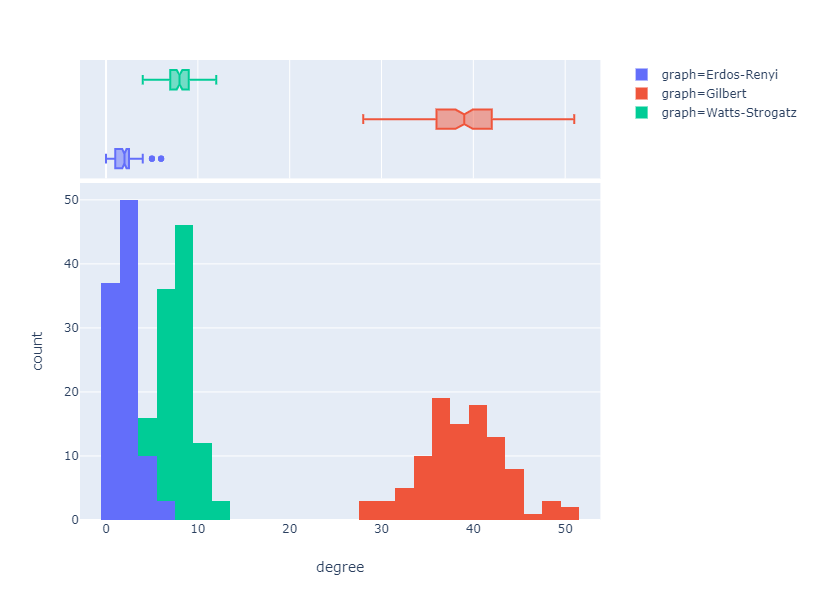

In [144]:
fig = px.histogram(
    nodes,
    x="degree",
    color="graph",
    nbins=nodes.degree.max(),
    marginal="box",
)
fig.show()

In [145]:

ER_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Erdos-Renyi") for node, cc in nx.algorithms.clustering(ER).items()]
)
Gilb_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Gilbert") for node, cc in nx.algorithms.clustering(Gilb).items()]
)
WS_cc = pd.DataFrame(
    [dict(node=node, clust_coef=cc, graph="Watts-Strogatz") for node, cc in nx.algorithms.clustering(WS).items()]
)
ccoef = ER_cc.append([Gilb_cc, WS_cc])

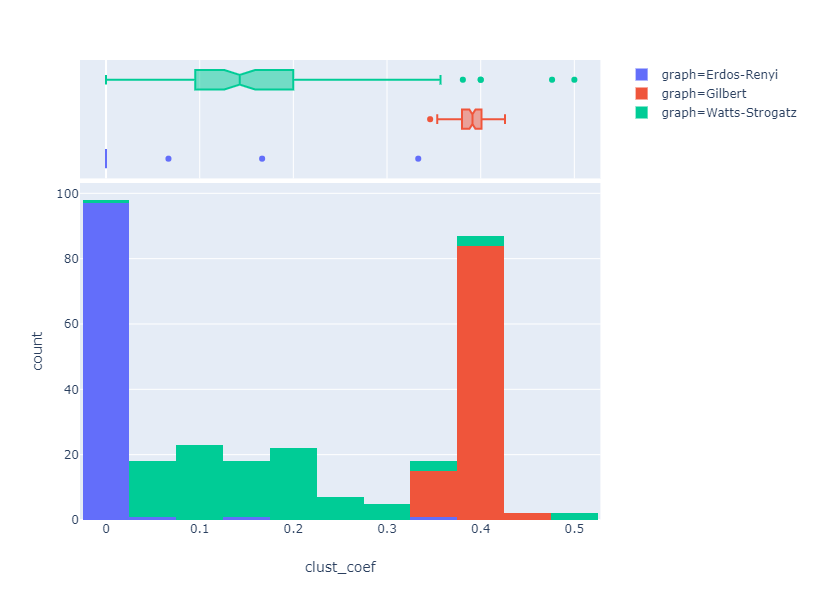

In [151]:
fig = px.histogram(
    ccoef,
    x="clust_coef",
    color="graph",
    marginal="box",
)
fig.show()

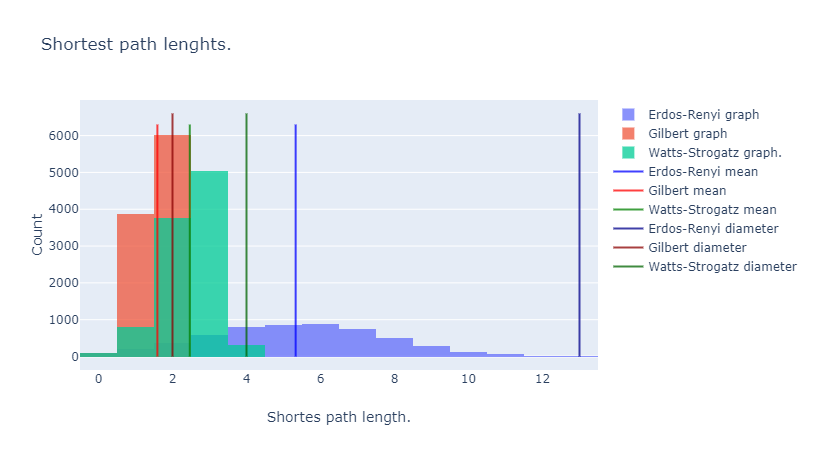

In [147]:
def extract_shortest_paths_lengths(G: nx.Graph) -> list:
    path_lengths = [] 
    for l in nx.shortest_path_length(G):
        path_lengths.extend(l[1].values())
    return path_lengths

ER_shortest = extract_shortest_paths_lengths(ER)
Gilb_shortest = extract_shortest_paths_lengths(Gilb)
WS_shortest = extract_shortest_paths_lengths(WS)
    
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=ER_shortest,
        name="Erdos-Renyi graph",
    )
)
fig.add_trace(
    go.Histogram(
        x=Gilb_shortest,
        name="Gilbert graph"
    )
)
fig.add_trace(
    go.Histogram(
        x=WS_shortest,
        name="Watts-Strogatz graph."
    )
)

ER_sp_mean = sum(ER_shortest)/len(ER_shortest)
Gilb_sp_mean = sum(Gilb_shortest)/len(Gilb_shortest)
WS_sp_mean = sum(WS_shortest)/len(WS_shortest)
fig.add_trace(
    go.Scatter(
        x=[
            ER_sp_mean,
            ER_sp_mean,
        ],
        hovertext="mean: {}".format(ER_sp_mean),        
        y = [0, 6300],
        mode="lines",
        line_color="Blue",
        name="Erdos-Renyi mean"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            Gilb_sp_mean,
            Gilb_sp_mean,
        ],
        hovertext="mean: {}".format(Gilb_sp_mean),
        y = [0, 6300],
        mode="lines",
        line_color="Red",
        name="Gilbert mean"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            WS_sp_mean,
            WS_sp_mean,
        ],
        hovertext="mean: {}".format(WS_sp_mean),
        y = [0, 6300],
        mode="lines",
        line_color="Green",
        name="Watts-Strogatz mean"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            max(ER_shortest),
            max(ER_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkBlue",
        name="Erdos-Renyi diameter"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            max(Gilb_shortest),
            max(Gilb_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkRed",
        name="Gilbert diameter"
    )
)
fig.add_trace(
    go.Scatter(
        x=[
            max(WS_shortest),
            max(WS_shortest),
        ],
        hovertext="diameter: {}".format(WS_sp_mean),
        y = [0, 6600],
        mode="lines",
        line_color="DarkGreen",
        name="Watts-Strogatz diameter"
    )
)
fig.update_layout(
    title_text="Shortest path lenghts.",
    xaxis_title_text="Shortes path length.",
    yaxis_title_text="Count",
    barmode='overlay',
)

fig.update_traces(opacity=0.75)
fig.show()

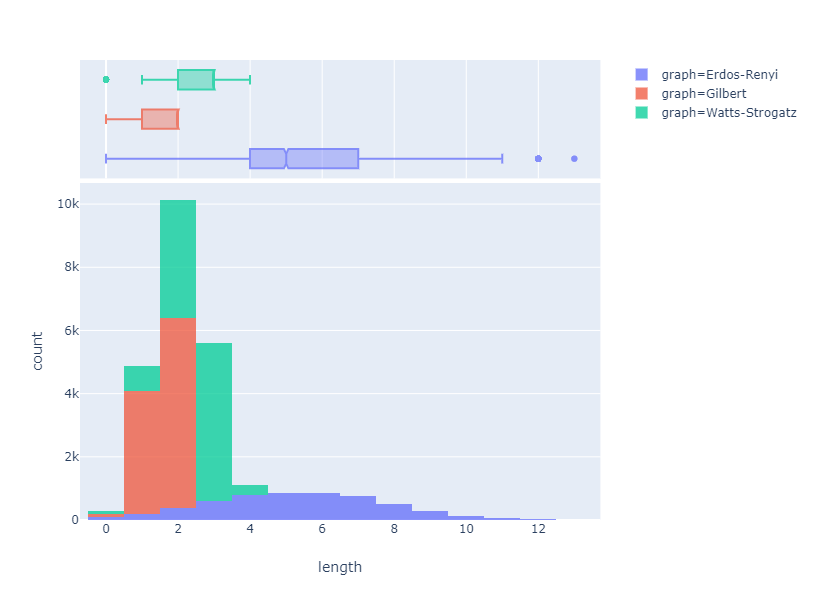

In [154]:
ER_sp = pd.DataFrame(
    [dict(length=length, graph="Erdos-Renyi") for length in ER_shortest]
)
Gilb_sp = pd.DataFrame(
    [dict(length=length, graph="Gilbert") for length in Gilb_shortest]
)
WS_sp = pd.DataFrame(
    [dict(length=length, graph="Watts-Strogatz") for length in WS_shortest]
)
short_paths = ER_sp.append([Gilb_sp, WS_sp])
fig = px.histogram(
    short_paths,
    x="length",
    color="graph",
    marginal="box",
)
# fig.update_layout(barmode="overlay")
fig.update_traces(opacity=0.75)
fig.show()